## Hyperdrive Exploration Simulation
This notebook is to explore the base functionality of Hyperdrive

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/"> simulation documentation</a>

### Install repo requirements & import packages

In [616]:
# test: skip-cell
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements-3.8.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [617]:
from __future__ import annotations

import numpy as np
from numpy.random._generator import Generator
import matplotlib.ticker as ticker

from elfpy import WEI
from elfpy.agents.agent import Agent
from elfpy.markets.hyperdrive import Market, MarketAction, MarketActionType
from elfpy.utils import sim_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.post_processing as post_processing
from elfpy.simulators import Config

### Setup experiment parameters

In [618]:
config = Config()

# General config parameters
config.title = "Hyperdrive Core Features"
config.pricing_model_name = "Hyperdrive" # can be yieldspace or hyperdrive

config.num_trading_days = 100 # Number of simulated trading days
config.num_blocks_per_day = 5 # Blocks in a given day (7200 means ~12 sec per block)
config.num_position_days = 90 # How long a token reaches maturity

config.trade_fee_percent = 0.05 # fee percent collected on trades
config.redemption_fee_percent = 0.05 # fee collected on the spread of the flat portion

config.target_fixed_apr = 0.03 # target fixed APR of the initial market after the LP
config.target_liquidity = 250_000 # target total liquidity of the initial market, before any trades

config.log_level = output_utils.text_to_log_level("INFO") # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
config.log_filename = "./hyperdrive_exploration.log" # Output filename for logging

config.shuffle_users = True

# Notebook specific parameters
num_longs = 1

# Define the vault apr
vault_apr = np.array([0.01] * config.num_trading_days)

#vault_apr[config.num_trading_days//2:] = 0.05
config.variable_apr = vault_apr.tolist()
config.freeze()

fig_size = (5, 5)

### Setup agents

In [619]:
class ShortAgent(Agent):
    """Opens Basic Short"""
    def action(self, market: Market):
        """implement user strategy"""
        return []

In [620]:
class LongAgent(Agent):
    """Opens Basic Long"""
    def action(self, market: Market):
        """implement user strategy"""
        long_balances = [long.balance for long in self.wallet.longs.values()]
        has_opened_long = bool(any(long_balance > 0 for long_balance in long_balances))

        if has_opened_long:
            return [
                self.create_agent_action(
                    action_type=MarketActionType.OPEN_LONG,
                    trade_amount=49_900,
                    mint_time=market.time
                )
            ]
        else:
            return []

In [621]:
class LPAgent(Agent):
    """Adds a large LP"""
    def action(self, market: Market):
        """implement user strategy"""
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list

### Instantiate Example Agents

In [622]:

def get_example_agents(rng: Generator, num_shorts: int, num_longs: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + num_longs):
        agent = LongAgent(
            wallet_address=address,
            budget=10_000,
        )
        agent.log_status_report()
        agents += [agent]
    existing_agents += len(agents)
    return agents

### Setup simulation objects

In [623]:
# define root logging parameters
output_utils.setup_logging(log_filename=config.log_filename, log_level=config.log_level)

# get an instantiated simulator object
# simulator = sim_utils.get_simulator(config)

### Run the simulation

In [624]:
bond_reserves = []
for x in np.arange(0, 5, 0.1):
    config.
    simulator = sim_utils.get_simulator(config)

    # add the random agents
    trading_agents = get_example_agents(
        rng=simulator.rng,
        num_shorts=0,
        num_longs=1,
        existing_agents=len(simulator.agents)
    )
    simulator.add_agents(trading_agents)
    print(f"Simulator has {len(simulator.agents)} agents")

    # run the simulation
    simulator.run_simulation()
    trades = post_processing.compute_derived_variables(simulator)
    bond_reserves += trades.iloc[0]["bond_reserves"]

print(bond_reserves)

Simulator has 2 agents
Simulator has 3 agents


AssertionError: pricing_models.check_input_assertions: ERROR: expected reserves_difference < 20000000000.0, not 1.3247516255648491e+20!

In [ ]:
# print(simulator.get_simulation_state_string())
# print(simulator.market.__dict__)

# convert simulation state to a pandas dataframe
# trades = post_processing.compute_derived_variables(simulator)
# print(trades.iloc[1]["lp_total_supply"])
# print(trades.iloc[1]["share_reserves"])
# print(trades.iloc[0]["bond_reserves"])
# print(trades.iloc[0]["share_reserves"])
# print(trades.iloc[2]["base_buffer"])
# print(trades.iloc[1]["agent_1_total_longs"])
# print(trades.iloc[1]["fixed_apr"])
# print(trades.keys())

### Charts

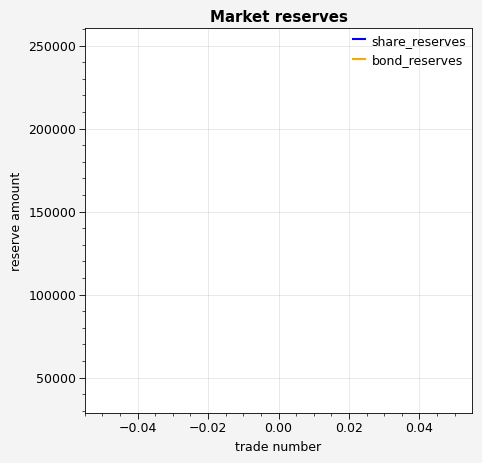

In [ ]:
fig, axes, _ = output_utils.get_gridspec_subplots(nrows=1, ncols=1)
ax = trades.iloc[:-1].plot(x="trade_number", y="share_reserves", ax=axes[0], c="blue")
ax = trades.iloc[:-1].plot(x="trade_number", y="bond_reserves", ax=axes[0], c="orange")
ax.set_xlabel("trade number")
ax.set_ylabel("reserve amount")
ax.set_title("Market reserves")
fig.set_size_inches(fig_size)